https://python.langchain.com/docs/use_cases/graph/quickstart/

langchain-openai==0.0.5, openai==1.21.2, langchain==0.1.16

**Start the Movie graph vectorDB in neo4j Desktop**

In [1]:
from dotenv import load_dotenv
import os
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
load_dotenv()

True

**Load OpenAI**

In [2]:
model_name = "gpt-35-turbo-1106"
azure_openai_api_key = os.environ["OPENAI_API_KEY"]
azure_openai_endpoint = os.environ["OPENAI_API_BASE"]

In [3]:
llm = AzureChatOpenAI(
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
    azure_deployment=model_name,
    model_name=model_name,
    temperature=0.0)

c:\Users\froozitalab\AppData\Local\anaconda3\envs\playaround\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.azure_openai.AzureChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import AzureChatOpenAI`.
  warn_deprecated(
c:\Users\froozitalab\AppData\Local\anaconda3\envs\playaround\Lib\site-packages\langchain_community\chat_models\azure_openai.py:167: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://cog-oai-dev-ce-002.openai.azure.com/ to https://cog-oai-dev-ce-002.openai.azure.com/openai.
  warnings.warn(
c:\Users\froozitalab\AppData\Local\anaconda3\envs

**Add Neo4j credentials**

In [4]:
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "moviesampleproject"
NEO4J_DATABASE = 'neo4j'

In [6]:
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE)

In [7]:
graph.refresh_schema()
print(graph.schema)

Node properties are the following:
Movie {imdbRating: FLOAT, id: STRING, released: DATE, title: STRING},Person {name: STRING},Genre {name: STRING}
Relationship properties are the following:

The relationships are the following:
(:Movie)-[:IN_GENRE]->(:Genre),(:Person)-[:DIRECTED]->(:Movie),(:Person)-[:ACTED_IN]->(:Movie)


### **Chain**

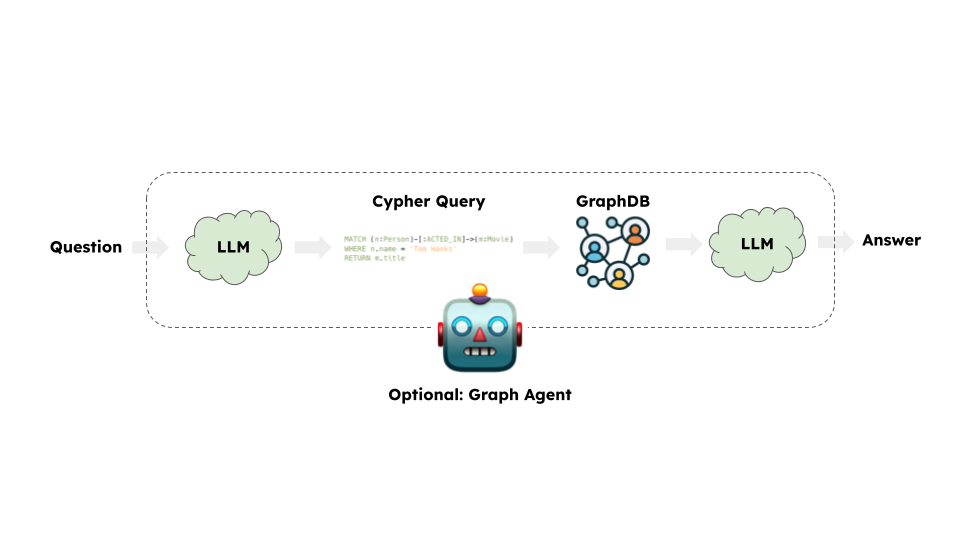

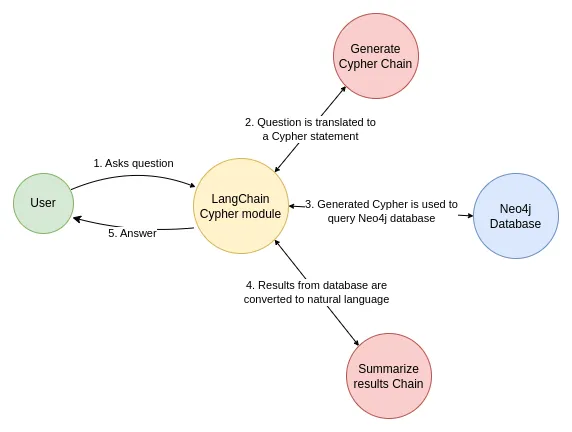

In [10]:
from langchain.chains import GraphCypherQAChain

chain = GraphCypherQAChain.from_llm(graph=graph, llm=llm, verbose=True)
response = chain.invoke({"query": "What was the cast of the Casino?"})
print(response)
print("\n", response["result"])



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (:Movie {title: "Casino"})<-[:ACTED_IN]-(actor:Person)
RETURN actor.name
Full Context:
[{'actor.name': 'Sharon Stone'}, {'actor.name': 'Joe Pesci'}, {'actor.name': 'James Woods'}, {'actor.name': 'Robert De Niro'}]

> Finished chain.
{'query': 'What was the cast of the Casino?', 'result': 'The cast of Casino included Sharon Stone, Joe Pesci, James Woods, and Robert De Niro.'}

 The cast of Casino included Sharon Stone, Joe Pesci, James Woods, and Robert De Niro.


**Validating relationship direction**

LLMs can struggle with relationship directions in generated Cypher statement. Since the graph schema is predefined, we can validate and optionally correct relationship directions in the generated Cypher statements by using the validate_cypher parameter.

In [11]:
chain = GraphCypherQAChain.from_llm(
    graph=graph, llm=llm, verbose=True, validate_cypher=True
)
response = chain.invoke({"query": "What was the cast of the Casino?"})
print(response)
print("\n", response["result"])



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (:Movie {title: "Casino"})<-[:ACTED_IN]-(actor:Person)
RETURN actor.name
Full Context:
[{'actor.name': 'Sharon Stone'}, {'actor.name': 'Joe Pesci'}, {'actor.name': 'James Woods'}, {'actor.name': 'Robert De Niro'}]

> Finished chain.
{'query': 'What was the cast of the Casino?', 'result': 'The cast of Casino included Sharon Stone, Joe Pesci, James Woods, and Robert De Niro.'}

 The cast of Casino included Sharon Stone, Joe Pesci, James Woods, and Robert De Niro.


### Strategies to improve graph database query generation by mapping values from user inputs to database

When using the built-in graph chains, the LLM is aware of the graph schema, but has no information about the values of properties stored in the database. Therefore, we can introduce a new step in graph database QA system to accurately map values.

**Detecting entities in the user input**

We have to extract the types of entities/values we want to map to a graph database. In this example, we are dealing with a movie graph, so we can map movies and people to the database.

In [12]:
from typing import List, Optional

from langchain.chains.openai_functions import create_structured_output_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person or movies appearing in the text",
    )


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting person and movies from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)


entity_chain = create_structured_output_chain(Entities, llm, prompt)

c:\Users\froozitalab\AppData\Local\anaconda3\envs\playaround\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `create_structured_output_chain` was deprecated in LangChain 0.1.1 and will be removed in 0.2.0. Use create_structured_output_runnable instead.
  warn_deprecated(


In [13]:
entities = entity_chain.invoke({"question": "Who played in Casino movie?"})
entities

{'question': 'Who played in Casino movie?',
 'function': Entities(names=['Casino'])}

Utilizing a simple CONTAINS clause to match entities to database. In practice, you might want to use a fuzzy search or a fulltext index to allow for minor misspellings.

In [15]:
match_query = """MATCH (p:Person|Movie)
WHERE p.name CONTAINS $value OR p.title CONTAINS $value
RETURN coalesce(p.name, p.title) AS result, labels(p)[0] AS type
LIMIT 1
"""

def map_to_database(values):
    result = ""
    for entity in values.names:
        response = graph.query(match_query, {"value": entity})
        try:
            result += f"{entity} maps to {response[0]['result']} {response[0]['type']} in database\n"
        except IndexError:
            pass
    return result


map_to_database(entities["function"])

'Casino maps to Casino Movie in database\n'

**Custom Cypher generating chain**

We need to define a custom Cypher prompt that takes the entity mapping information along with the schema and the user question to construct a Cypher statement. We will be using the LangChain expression language to accomplish that.

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Generate Cypher statement based on natural language input
cypher_template = """Based on the Neo4j graph schema below, write a Cypher query that would answer the user's question:
{schema}
Entities in the question map to the following database values:
{entities_list}
Question: {question}
Cypher query:"""  # noqa: E501

cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input question, convert it to a Cypher query. No pre-amble.",
        ),
        ("human", cypher_template),
    ]
)

cypher_response = (
    RunnablePassthrough.assign(names=entity_chain)
    | RunnablePassthrough.assign(
        entities_list=lambda x: map_to_database(x["names"]["function"]),
        schema=lambda _: graph.get_schema,
    )
    | cypher_prompt
    | llm.bind(stop=["\nCypherResult:"])
    | StrOutputParser()
)

In [17]:
cypher = cypher_response.invoke({"question": "Who played in Casino movie?"})
cypher

'MATCH (p:Person)-[:ACTED_IN]->(:Movie {title: "Casino"})\nRETURN p.name'

**Generating answers based on database results**

Now that we have a chain that generates the Cypher statement, we need to execute the Cypher statement against the database and send the database results back to an LLM to generate the final answer. Again, we will be using LCEL

In [18]:
from langchain.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher validation tool for relationship directions
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in graph.structured_schema.get("relationships")
]
cypher_validation = CypherQueryCorrector(corrector_schema)

# Generate natural language response based on database results
response_template = """Based on the the question, Cypher query, and Cypher response, write a natural language response:
Question: {question}
Cypher query: {query}
Cypher Response: {response}"""

response_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input question and Cypher response, convert it to a natural"
            " language answer. No pre-amble.",
        ),
        ("human", response_template),
    ]
)

chain = (
    RunnablePassthrough.assign(query=cypher_response)
    | RunnablePassthrough.assign(
        response=lambda x: graph.query(cypher_validation(x["query"])),
    )
    | response_prompt
    | llm
    | StrOutputParser()
)

In [19]:
chain.invoke({"question": "Who played in Casino movie?"})

'Sharon Stone, Joe Pesci, James Woods, and Robert De Niro played in the movie "Casino".'